# WIP コーヒースタンドのシミュレーションをしてみた

これは [VOYAGE GROUP Advent Canlendar 2016](http://techlog.voyagegroup.com/entry/advent2016) の3日目のエントリです。

こんにちは、最近RよりもPythonを書いてお仕事している yuu_ito です。

弊社ではバリスタさんが美味しいコーヒーを淹れてくれるサービスがあるのですが、

オススメです。もし弊社に商談などで寄る際はぜひ注文してみてください。

https://www.instagram.com/officecafe_garden/


#### ところで「一体何人バリスタさんが居ればイイカンジに運営できるのでしょう？」

今回は最近業務で使い始めたPythonでシミュレーションしてみます。

Python シミュレーションフレームワークである[SimPy](http://simpy.readthedocs.io/en/latest/)を使って実装します。

コードはこの記事を読んでわかる通り[Jupyter](http://jupyter.org/)で以下に書いていきます。

(Jupyter notebookって本当に便利ですよね！)

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import simpy

%matplotlib inline

In [73]:
STATE_FILE = "./state.csv"
def log_state(m):
    # 実行結果をファイルに追記
    with open(STATE_FILE,"a") as f:
        f.write(m+"\n")

def get_state_results():
    return pd.read_csv(STATE_FILE)

def reset_state():
    # ファイルのクリア
    with open(STATE_FILE,"w") as f:
        f.write("name,time,state\n")

class Person(object):
    def __init__(self, env, name, freq, coffee_garden):
        self.env = env
        self.name = name
        self.freq = freq
        self.coffee_garden = coffee_garden

    def needs_coffee(self):
        # 一定の確率でコーヒーが飲みたくなる
        if np.random.randint(SIM_SIZE)  <= self.freq:
                log_state("%s,%d,コーヒー飲みたい！" % (self.name, self.env.now))
                return True
        else:
                log_state("%s,%d,仕事しよ..." % (self.name, self.env.now))
                return False

    def run(self):
        # シミュレータが実行するメソッド。毎ループごとにコーヒーを飲みにいくか判断する
        while True:
            if self.needs_coffee():
                with self.coffee_garden.request() as req:
                    yield req
                    yield self.env.timeout(1) # コーヒーを淹れる時間
                    log_state("%s,%d,おいしかった！！" % (self.name, self.env.now))
            yield self.env.timeout(1)

ざっとコード貼ってしまいましたが、


大事なとこは **Personクラス** でもつ **env** 変数と **run()** メソッドです。

このあとメインとなるシミュレーションの実行処理を書くのですが、その処理が

上の **Personクラス** のオブジェクトから **run()** メソッドを実行するように設定します。

以下がシミュレータの準備のコードになります。

In [75]:
SIM_SIZE = 10  # ループを回す回数
FREQ = 1  # Personがコーヒーを飲みに行きたくなる頻度
NUM_OF_PEOPLE = 5 # Personの人数

# simpy のEnvironmentオブジェクトを生成
env = simpy.Environment()

# コーヒースタンドオブジェクトの生成
coffee_garden = simpy.Resource(env, 2)

# Personオブジェクトを生成。runメソッドをプロセスとして設定
for name in ["person_%03d" % i for i in np.arange(0,NUM_OF_PEOPLE,1)]:
    env.process(Person(env, name, FREQ, coffee_garden).run())

SimPy 特有の処理の書き方ですが、

複数のプロセス（今回だと**Personオブジェクト**）が共有するモノに対して処理を行う場合、

またそのモノに容量の制限があるオブジェクトを用意したいときは[simpy.Resource](http://simpy.readthedocs.io/en/latest/simpy_intro/shared_resources.html)オブジェクトを利用します。

今回だとバリスタさんとコーヒースタンドの場所がそれにあたります。

それでは実際に実行してみましょう。

In [76]:
reset_state()
env.run(until=SIM_SIZE)

csvファイルが吐かれているはずです。読み込んでデータを可視化してみましょう。

In [77]:
dat = get_state_results()
dat.head()

,name,time,state
0,person_000,0,仕事しよ...
1,person_001,0,仕事しよ...
2,person_002,0,仕事しよ...
3,person_003,0,仕事しよ...
4,person_004,0,仕事しよ...


In [78]:
# データフレームを整形して見やすく。
dat.pivot("time","name","state")

name,person_000,person_001,person_002,person_003,person_004
time,,,,,
0,仕事しよ...,仕事しよ...,仕事しよ...,仕事しよ...,仕事しよ...
1,コーヒー飲みたい！,コーヒー飲みたい！,仕事しよ...,仕事しよ...,仕事しよ...
2,おいしかった！！,おいしかった！！,仕事しよ...,仕事しよ...,仕事しよ...
3,仕事しよ...,仕事しよ...,コーヒー飲みたい！,仕事しよ...,仕事しよ...
4,仕事しよ...,仕事しよ...,おいしかった！！,コーヒー飲みたい！,仕事しよ...
5,仕事しよ...,仕事しよ...,仕事しよ...,おいしかった！！,仕事しよ...
6,仕事しよ...,仕事しよ...,仕事しよ...,コーヒー飲みたい！,仕事しよ...
7,コーヒー飲みたい！,コーヒー飲みたい！,仕事しよ...,おいしかった！！,仕事しよ...
8,おいしかった！！,おいしかった！！,仕事しよ...,仕事しよ...,仕事しよ...


意図通りに動いているぽいので、シミュレーションのシナリオを整理して設定してみます。

## シミュレーション・シナリオ

- 社内の就業時間（８時間）中に注文できる。
- 毎日行く人もいると思うけど社員全員ではないはず。１日 0〜2回のランダムで
- 社員数は３００人。だいたい弊社こんなものだったはず。
- バリスタさんは3人常駐してくれている。
- 注文から淹れるのに３分ほど時間がかかるとする。

1ループを1分としてシミュレーションを行うとすると、8時間＝60分 x 8 = 480ループになります。

バリスタさんも休憩したりで、全員がいない場合もあると思いますがとりあえず３人固定で。

待ち人数については毎単位時間ごとに並んでる人をモニタリングする処理を追加します。

In [79]:
# スタンドの前で待つ人のモニタリング
def monitor(resource, env):
    while True:
        # バリスタさんにコーヒーを淹れてもらっている人数
        log_state("Brewing,%d,%d" % (resource._env.now, resource.count))
        # キャパ越えで待ってる人
        log_state("Waiting,%d,%d" % (resource._env.now, len(resource.queue)))
        yield env.timeout(1)

それぞれのPersonの動きには興味はなくなったので、結果を返す処理を除いておきます。

In [83]:
class Person(object):
    def __init__(self, env, name, freq, coffee_garden):
        self.env = env
        self.name = name
        self.freq = freq
        self.coffee_garden = coffee_garden

    def needs_coffee(self):
        return np.random.randint(SIM_SIZE) < self.freq

    def run(self):
        while True:
            if self.needs_coffee():
                with self.coffee_garden.request() as req:
                    yield req
                    yield self.env.timeout(COFFEE_TIME) # コーヒーを淹れる時間
            yield self.env.timeout(1)

パラメタを再設定して改めてシミュレータを実行してみます。

In [87]:
SIM_SIZE = 60*8  # ループを回す回数
MAX_FREQ = 2  # Personがコーヒーを飲みに行きたくなる最大頻度
NUM_OF_PEOPLE = 300  # 人数
NUM_OF_BRISTA = 3  # バリスタさんの人数
COFFEE_TIME = 3  # コーヒーの淹れてくれる時間

# 人ごとにコーヒーの飲みたくなる頻度を設定
def get_random_freq():
    return np.random.randint(MAX_FREQ)

# simpy のEnvironmentオブジェクトを生成
env = simpy.Environment()

coffee_garden = simpy.Resource(env, NUM_OF_BRISTA)

# Personオブジェクトを生成しrunメソッドをプロセスとして設定
for name in ["person_%03d" % i for i in np.arange(0,NUM_OF_PEOPLE,1)]:
    env.process(Person(env, name, get_random_freq(), coffee_garden).run())

# コーヒースタンドのモニタリング処理
env.process(monitor(coffee_garden, env))
    
reset_state()    
env.run(until=SIM_SIZE)

やっとここからが本題です。(コードばかりで全く文章書いていないですが...!?

１日のうちに待っている人数がどのくらいの頻度で起きていたのでしょう。

ヒストグラムを見てみます。

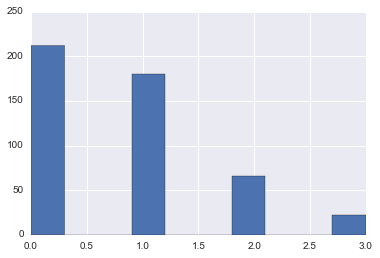

In [88]:
res = dat.pivot("time","name","state")
res.Brewing.hist()

Brewing(コーヒーを淹れてもらっている状態)の人数が左から 0,1,2,3 となり

一番右が、バリスタの方３人が同時にコーヒーを淹れている状態です。

50に達していないので、1日(60x8=480)のうちの1割程度です。

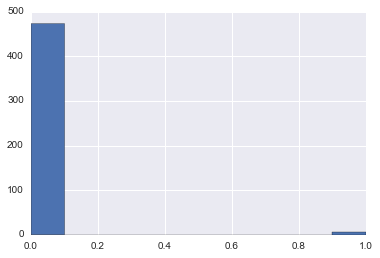

In [89]:
res.Waiting.hist()

次はWaiting(前に先約がいて待ちの状態)のヒストグラムです。

待ち人数が1ごくわずかですね。基本的に待たずに注文ができているようです。

**バリスタさん３人がいれば、弊社の社員数であればほぼ待たずにコーヒーを注文できるようです。良かったです。**

In [97]:
def get_hist_data(simulate_data):
    d = simulate_data.pivot("time","name","state")
    return dict(Counter(d.Brewing)), dict(Counter(d.Waiting))

def simulate():
    i = 0
    # 人ごとにコーヒーの飲みたくなる頻度を設定
    def get_random_freq():
        return np.random.randint(MAX_FREQ)

    SIM_SIZE = 60*8  # ループを回す回数
    MAX_FREQ = 2  # Personがコーヒーを飲みに行きたくなる最大頻度
    NUM_OF_PEOPLE = 300  # 人数
    NUM_OF_BRISTA = 3  # バリスタさんの人数
    COFFEE_TIME = 3  # コーヒーの淹れてくれる時間

    # simpy のEnvironmentオブジェクトを生成
    env = simpy.Environment()
    
    coffee_garden = simpy.Resource(env, NUM_OF_BRISTA)
    
    # Personオブジェクトを生成しrunメソッドをプロセスとして設定
    for name in ["person_%03d" % i for i in np.arange(0,NUM_OF_PEOPLE,1)]:
        env.process(Person(env, name, get_random_freq(), coffee_garden).run())
    
    # コーヒースタンドのモニタリング処理
    env.process(monitor(coffee_garden, env))
    
    reset_state()    
    env.run(until=SIM_SIZE)
    return get_hist_data(get_state_results())

In [125]:
# brew_stats = []
# wait_stats = []
for i in np.arange(0,10,1):
    b, w = simulate()
    brew_stats.append(b)
    wait_stats.append(w)
    

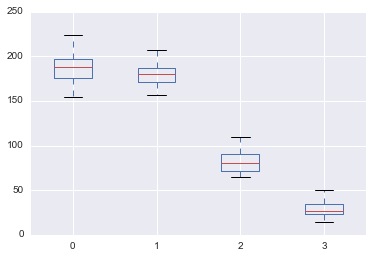

In [126]:
pd.DataFrame(brew_stats).boxplot()

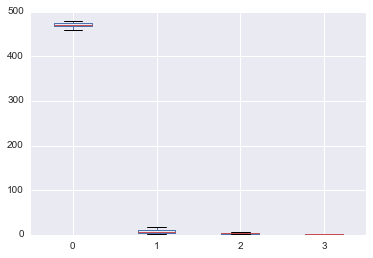

In [127]:
pd.DataFrame(wait_stats).boxplot()

In [48]:
dat = get_state_results()
dat

,name,time,state
0,Brewing,0,0
1,Waiting,0,0
2,Brewing,1,0
3,Waiting,1,0
4,Brewing,2,0
5,Waiting,2,0
6,Brewing,3,0
7,Waiting,3,0
8,Brewing,4,0
9,Waiting,4,0


## 

## 結果

あまり現実的でないので、もう少しシナリオを追加してみます。

## シナリオの追加

- 注文から淹れるのに３〜５分
- 就業時間中に０〜２回注文する
- 注文するときに他に仲間を0~3人つれていく


## 結果

- 現実には程遠いが、それなりに良い判断材料になりそう。

## まとめ

In [ ]:
# スタンドの前で待つ人のモニタリング
def monitor(resource, env):
    while True:
        log_state("Brewing,%d,%d" % (resource._env.now, resource.count))
        log_state("Waiting,%d,%d" % (resource._env.now, len(resource.queue)))
        yield env.timeout(1)

In [ ]:
STATE_FILE = "./state.csv"
def log_state(m):
    with open(STATE_FILE,"a") as f:
        f.write(m+"\n")

def reset_state():
    with open(STATE_FILE,"w") as f:
        f.write("")

class Person(object):
    def __init__(self, env, name, freq):
        self.env = env
        self.name = name
        self.freq = freq

    def needs_coffee(self):
        return np.random.randint(SIM_SIZE) < self.freq

    def run(self):
        while True:
            if self.needs_coffee():
                with coffee_garden.request() as req:
                    yield req
                    yield self.env.timeout(2) # コーヒーを淹れる時間
                    #log_state("%s,%d,おいしかった！！" % (self.name, self.env.now))
            yield self.env.timeout(1)


In [ ]:
SIM_SIZE = 60*8
NUM_OF_PEOPLE = 300
NUM_OF_BRISTA = 3
COFFEE_TIME = 3
MAX_FREQ = 2

def get_random_freq():
    return np.random.randint(MAX_FREQ)

env = simpy.Environment()

coffee_garden = simpy.Resource(env, NUM_OF_BRISTA)

for name in ["person_%03d" % i for i in np.arange(0,NUM_OF_PEOPLE,1)]:
    env.process(Person(env, name, get_random_freq()).run())

env.process(monitor(coffee_garden, env))
    
reset_state()    
env.run(until=SIM_SIZE)

In [ ]:
dat = pd.read_csv("./state.csv", header=None)
dat.columns=["name","time","state"]
res = dat.pivot("time","name","state")
res.hist()

# グラフを見て分析してみる

- Brewing(コーヒーを淹れてもらっている状態) の最大は２なので、バリスタさんが２人を相手にコーヒーを淹れてるタイミングがある。１００前後なので１日の2割弱。
- Waiting(先客がいて注文できていない状態)の最大は１、かつ１日のうちのごくわずか。

３人もいてくれればほとんど待たずにコーヒーが飲める！！

# さらに現実ぽくシナリオを組んでみる

- 1単位時間を１分として営業時間の８時間＝60min x 8
- 毎日行く人もいると思うけど全員ではない。FREQも１日０回〜2回のランダムで
    - [NEW！！] 朝の１時間、昼休みの１時間はよりコーヒーを飲みたくなる
- 社員数は３００人
- バリスタさんは3人常駐してくれている。
- [NEW!!] たまに仲間を１〜２人連れてコーヒーを買いに行く。


In [ ]:
STATE_FILE = "./state.csv"

# スタンドの前で待つ人のモニタリング
def monitor(resource, env):
    while True:
        #log_state("Brewing,%d,%d" % (resource._env.now, resource.count))
        #log_state("Waiting,%d,%d" % (resource._env.now, len(resource.queue)))
        yield env.timeout(1)

def log_state(m):
    with open(STATE_FILE,"a") as f:
        f.write(m+"\n")

def reset_state():
    with open(STATE_FILE,"w") as f:
        f.write("")

def is_morning(current_time):
    return current_time > 0 and current_time < 24

def is_after_lanch(current_time):
    return current_time > 24*12 and current_time < 24*13

class Person(object):
    people = []
    def __init__(self, env, name, freq):
        self.env = env
        self.name = name
        self.freq = freq
        self.accompanied = False

    def needs_coffee(self):
        freq = self.freq
        if is_morning(self.env.now):
            freq = self.freq + 1

        if is_after_lanch(self.env.now):
            freq = self.freq + 1
        
        return np.random.randint(SIM_SIZE) < freq

    def accompany_someone(self):
        if self.accompanied:
            return None  # すでに誘ったメンバー
        for i in range(0, np.random.randint(2),1):
            pid = np.random.randint(NUM_OF_PEOPLE)
            self.people[pid].accompanied=True
    
    def run(self):
        while True:
            if self.needs_coffee() or self.accompanied:
                self.accompany_someone()
                with coffee_garden.request() as req:
                    yield req
                    if self.accompanied:
                        log_state("%s,%d,さそわれて。" % (self.name, self.env.now))
                    else:
                        log_state("%s,%d,飲みに来た。" % (self.name, self.env.now))
                    yield self.env.timeout(2) # コーヒーを淹れる時間
                    #log_state("%s,%d,おいしかった！！" % (self.name, self.env.now))
            self.accompanied = False
            yield self.env.timeout(1)


In [ ]:
SIM_SIZE = 60*8
NUM_OF_PEOPLE = 300
NUM_OF_BRISTA = 2
FREQ_FOR_ACCOMPANY = 1

def get_random_freq():
    return np.random.randint(2)

env = simpy.Environment()

coffee_garden = simpy.Resource(env, NUM_OF_BRISTA)

for name in ["person_%03d" % i for i in np.arange(0,NUM_OF_PEOPLE,1)]:
    p = Person(env, name, get_random_freq())
    Person.people.append(p)
    env.process(p.run())

env.process(monitor(coffee_garden, env))
    
reset_state()    
env.run(until=SIM_SIZE)

In [ ]:
from collections import Counter

In [69]:
dat = pd.read_csv("./state.csv", header=None)
dat.columns=["name","time","state"]
Counter(dat.state.values)
#res = dat.pivot("time","name","state")
#res

Counter({'0': 664, '1': 177, '2': 89, '3': 30, 'state': 1})

In [71]:
dict(Counter(dat.state.values))

{'0': 664, '1': 177, '2': 89, '3': 30, 'state': 1}